# Introduction (part 2): `Operator` `apply` and `arguments`


## Goals

- Describe two fundamental user APIs:
    * `Operator.apply`
    * `Operator.arguments`
- Describe the `Data` objects associated with functions
- Investigate how these `Data` objects are updated during time loops

We will use a trivial `Operator` that, at each time step, increments by 1 all points in the physical domain.

In [1]:
from devito import Grid, TimeFunction, Eq, Operator

grid = Grid(shape=(4, 4))
u = TimeFunction(name='u', grid=grid, save=3)
update = Eq(u.forward, u + 1)
op = Operator(update)

To run `op`, we have to "`apply`" it.

In [2]:
#NBVAL_IGNORE_OUTPUT
summary = op.apply()

Operator `Kernel` ran in 0.01 s


Under-the-hood, some code has been generated (`print(op)` to display the generated code), JIT-compiled, and executed. Since no additional arguments have been passed, `op` has used `u` as input. We can verify that the content of `u.data` is as expected

In [3]:
u.dimensions, u.shape
# 3 = save parameters

((time, x, y), (3, 4, 4))

In [4]:
u.data

Data([[[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]],

      [[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]],

      [[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]]], dtype=float32)

In particular, we observe that:

* `u` has size 3 along the time dimension, since it was built with `save=3`. Therefore `op` could only execute 2 timesteps, namely time=0 and time=1; given `Eq(u.forward, u + 1)`, executing time=2 would cause out-of-bounds access errors. Devito figures this out automatically and sets appropriate minimum and maximum iteration points.
* All 16 points in each timeslice of the 4x4 `Grid` have been computed.

To access all default arguments used by `op` *without* running the `Operator`, one can run

In [5]:
#NBVAL_IGNORE_OUTPUT
op.arguments()

{'u': <cparam 'P' (0x11995fe30)>,
 'time_m': 0,
 'time_size': 3,
 'time_M': 1,
 'x_m': 0,
 'x_size': 4,
 'x_M': 3,
 'y_m': 0,
 'y_size': 4,
 'y_M': 3,
 'h_x': 0.33333334,
 'h_y': 0.33333334,
 'o_x': 0.0,
 'o_y': 0.0,
 'timers': <cparam 'P' (0x1199b7a20)>}

In [6]:
# time_m: first time
# time_size: size of the ojbect 
# time_M: final
# x_m: first node in x dimension
# x_size: size in x dimension
# x_m:final value of x

`'u'` stores a pointer to the allocated data; `'timers'` stores a pointer to a data structure used for C-level performance profiling.

One may want to replace some of these default arguments. For example, we could increase the minimum iteration point along the spatial Dimensions `x` and `y`, and execute only the very first timestep:

In [7]:
#NBVAL_IGNORE_OUTPUT
u.data[:] = 0.  # Explicit reset to initial value
summary = op.apply(x_m=2, y_m=2, time_M=0)

Operator `Kernel` ran in 0.01 s


We look again at the computed data to convince ourselves that everything went as intended to go

In [8]:
u.data

Data([[[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]],

      [[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.]],

      [[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]], dtype=float32)

Given a generic `Dimension` `d`, the naming convention is such that:

* `d_m` is the minimum iteration point
* `d_M` is the maximum iteration point

Hence, `op.apply(..., d_m=4, d_M=7, ...)` will run `op` in the compact interval `[4, 7]` along `d`. For historical reasons, `d=...` aliases to `d_M=...`; in many Devito examples it happens to see `op.apply(..., time=10, ...)` -- this is just equivalent to `op.apply(..., time_M=10, ...)`.

If we try to specify an invalid iteration extreme, Devito will raise an exception.

In [9]:
from devito.exceptions import InvalidArgument
try:
    op.apply(time_M=2)
except InvalidArgument as e:
    print(e)

OOB detected due to time_M=2


The same `Operator` can be applied to a different `TimeFunction`. For example:

In [10]:
#NBVAL_IGNORE_OUTPUT
u2 = TimeFunction(name='u', grid=grid, save=5)
summary = op.apply(u=u2)

Operator `Kernel` ran in 0.01 s


In [11]:
u2.data

Data([[[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]],

      [[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]],

      [[2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.],
       [2., 2., 2., 2.]],

      [[3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.]],

      [[4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.]]], dtype=float32)

Note that this was the third call to `op.apply`, but code generation and JIT-compilation only occurred upon the very first call.

There is one relevant case in which the maximum iteration point along the time dimension must be specified -- whenever `save` is unset, as in such a case the `Operator` wouldn't know for how many iterations to run.

In [12]:
v = TimeFunction(name='v', grid=grid)
op2 = Operator(Eq(v.forward, v + 1))
try:
    op2.apply()
except ValueError as e:
    print(e)

No value found for parameter time_M


In [13]:
#NBVAL_IGNORE_OUTPUT
summary = op2.apply(time_M=4)

Operator `Kernel` ran in 0.01 s


In [14]:
v.data

Data([[[4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.],
       [4., 4., 4., 4.]],

      [[5., 5., 5., 5.],
       [5., 5., 5., 5.],
       [5., 5., 5., 5.],
       [5., 5., 5., 5.]]], dtype=float32)

The `summary` variable can be inspected to retrieve performance metrics.

In [15]:
#NBVAL_IGNORE_OUTPUT
summary

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

We observe that basically all entries except for the execution time are fixed at 0. This is because by default Devito avoids to compute performance metrics, to minimize the processing time before returning control to the user (in complex `Operators`, the processing time to retrieve, for instance, the operation count or the memory footprint could be significant). To compute all performance metrics, a user could either export the environment variable `DEVITO_PROFILING` to `'advanced'` or change the profiling level programmatically *before* the `Operator` is constructed

In [16]:
#NBVAL_IGNORE_OUTPUT
from devito import configuration
configuration['profiling'] = 'advanced'

op = Operator(Eq(u.forward, u*u + 1.))
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=1e-06, gflopss=0.064, gpointss=0.032, oi=0.16666666666666666, ops=2, itershapes=((2, 4, 4),)))])

A `PerformanceSummary` will contain as many entries as "sections" in the generated code. Currently, there is no way to automatically tie a compiler-generated section to the user-provided `Eq`s (in general, there can be more than one `Eq` in a section). The only option is to look at the generated code and search for bodies of code wrapped within C comments such as
```
/* Begin section0 */
<code>
/* End section0 \*/"
```
For example

In [17]:
# Uncomment me and search for /* Begin section0 */ ... /* End section0 */
# print(op)

In [18]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound
dt = 0.004 # (dt < 0.42*dx/c)

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const


from devito import TimeFunction, Grid, Eq, solve

grid = Grid(shape=l, extent=L)
t_s = grid.stepping_dim
u = TimeFunction(grid=grid, time_order=2, space_order=2, name='u')
pde = Eq(1/c**2 * u.dt2 - u.dx2, 0)
stencil = solve(pde, u.forward)
update = Eq(u.forward, stencil)

u.data[0] = u_e(x, 0)
u.data[1] = u_e(x, dt)

# boundary

bc = [Eq(u[t_s+1, 0], 0)]
bc = bc + [Eq(u[t_s+1, -1], 0)]

op = Operator([update]+ bc)

In [19]:
op.apply(dt=dt, time=4999)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.001478999999999978, gflopss=40.60039756592352, gpointss=3.383366463826961, oi=1.496410289228296, ops=12, itershapes=((4999, 1001),)))])

In [20]:
op(dt=dt, time_M=4999)

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.0017129999999999687, gflopss=35.05428371278523, gpointss=2.9211903093987694, oi=1.496410289228296, ops=12, itershapes=((4999, 1001),)))])

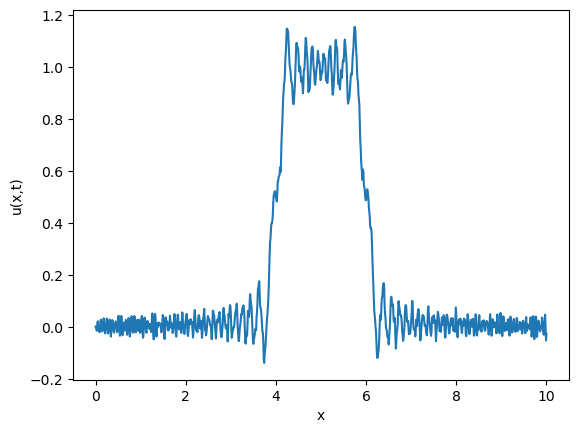

In [21]:
%matplotlib inline
# Lets plot some Devito results:
plt.plot(x, u.data[mod(5000,3), :])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.show()

In the `PerformanceSummary`, associated to `section0` is a `PerfEntry`, whose entries represent:

* time: The time, in seconds, to execute the section.
* gflopss: Performance of the section in Gigaflops per second.
* gpointss: Performance of the section in Gigapoints per second.
* oi: Operational intensity.
* ops: Floating point operations at each (innermost loop) iteration.
* itershape: The shape of the iteration space.

# Excersie: Comparison against exact solution

Consider the following boundary value problem for the 1D wave equation:

\begin{align}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}(x,t)-\frac{\partial^2 u}{\partial x^2}(x,t)&=0, \\
  u(0,t)=u(10,t)&= 0, \\
  \frac{\partial u}{\partial t}(x,0)&=0, \\
  u(x,0)&=
    \begin{cases}
      0, & 0 \leq x < 4,\\
      1, & 4 \leq x \leq 6,\\
      0, & 6 < x \leq 10.
    \end{cases}
\end{align}

The initial state is illustrated in the figure below:

<img src="figures/exact_solution.png" width="450" height="450" align="center"/>

It can be shown that the analytical solution to this problem is:
\begin{equation}
 u(x,t)=\sum_{n=1}^{\infty}A_{n}\sin\left(\frac{n\pi x}{10}\right)\cos\left(\frac{n\pi ct}{10}\right),
\end{equation}
where
\begin{equation}
  A_n=\frac{2}{n\pi}\left[\cos\left(\frac{4n\pi}{10}\right)-\cos\left(\frac{6n\pi}{10}\right)\right].
\end{equation}

Below is a snippet of code to plot the exact result at any point in time. You can use it to explore the evolution of the wave:

In [22]:
from numpy import sin, cos, pi, linspace, shape, zeros, mod

import matplotlib.pyplot as plt

# Global constants
L = 10. # Define length of domain as a global variable
N = 2000 # Number of terms in the Fourier sine series
l = 1001 # Define number of points in domain
c = 1.0 # Speed of sound

x = linspace(0, L, l) # x axis for calling u(x, t) at given t

# Calculate exact solution

def u_e(x, t):
    s = zeros(x.size)
    for i in range(1,N+1):
        s+=A_n(i)*sin(i*pi*x/L)*cos(i*pi*c*t/L)
    return s

def A_n(n):
    const = 2/n/pi*(cos(4*n*pi/L)-cos(6*n*pi/L))
    return const

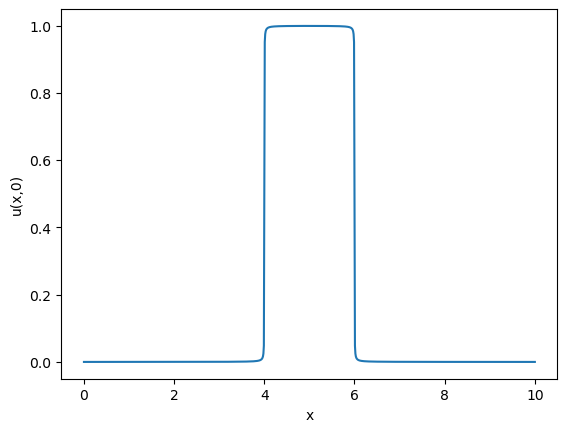

In [23]:
%matplotlib inline
# Plot solution at a point T in time
T = 0
plt.plot(x, u_e(x, T))
plt.xlabel('x')
plt.ylabel('u(x,0)')
plt.show()

How would you write a Devito code to compute the evolution in time of the wave?

In [24]:
# Some hints:

# Required imports
from devito import Grid, TimeFunction, Eq, solve, Operator

# Define the grid/computational domain
grid = Grid(shape=(l), extent=(L))
t_s = grid.stepping_dim

# Wavefield
u = TimeFunction(name='u', grid=grid, time_order=2, space_order=2)

dx = abs(x[1]-x[0])
# Critical time-step
dt = 0.004 # (dt < 0.42*dx/c)

# Set the initial conditions
u0 = u_e(x, 0)
u1 = u_e(x, dt)
u.data[0,:] = u0
u.data[1,:] = u1

# Boundary conditions can be defined by additional equations:
bc = [Eq(u[t_s+1, 0], 0)]
bc += [Eq(u[t_s+1, -1], 0)]

# Note -- Boundary conditions can be added to an operator as follows:
# op = Operator([eq]+bc)

See `nb2_exercise.ipynb` in additional the `additional_material` folder for a working solution.